In [1]:
import cmocean
import dask.distributed as dsk
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39141/status,
Dashboard: /proxy/39141/status,Workers: 4
Total threads: 8,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36613,Workers: 4
Dashboard: /proxy/39141/status,Total threads: 8
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:34231,Total threads: 2
Dashboard: /proxy/40389/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:46173,


In [2]:
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu']
hu = hu.sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90,-50.1,.1))), 1, np.nan)
land_ice_mask = land_ice_mask.interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, 
                                     land_ice_mask['lon'] + 360, 
                                     land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon':'_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj':sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj':'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_lin = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [3]:
u = xr.open_dataset('../data/uas-monthly-1979_2015-cmip6.nc')['uas'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time')
v = xr.open_dataset('../data/vas-monthly-1979_2015-cmip6.nc')['vas'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time')
p = xr.open_dataset('../data/psl-monthly-1979_2015-cmip6.nc')['psl'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time')

In [4]:
up = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas'].sel(time = slice('2090-01-01', '2100-01-01')).mean('time')
vp = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas'].sel(time = slice('2090-01-01', '2100-01-01')).mean('time')
pp = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc')['psl'].sel(time = slice('2090-01-01', '2100-01-01')).mean('time')

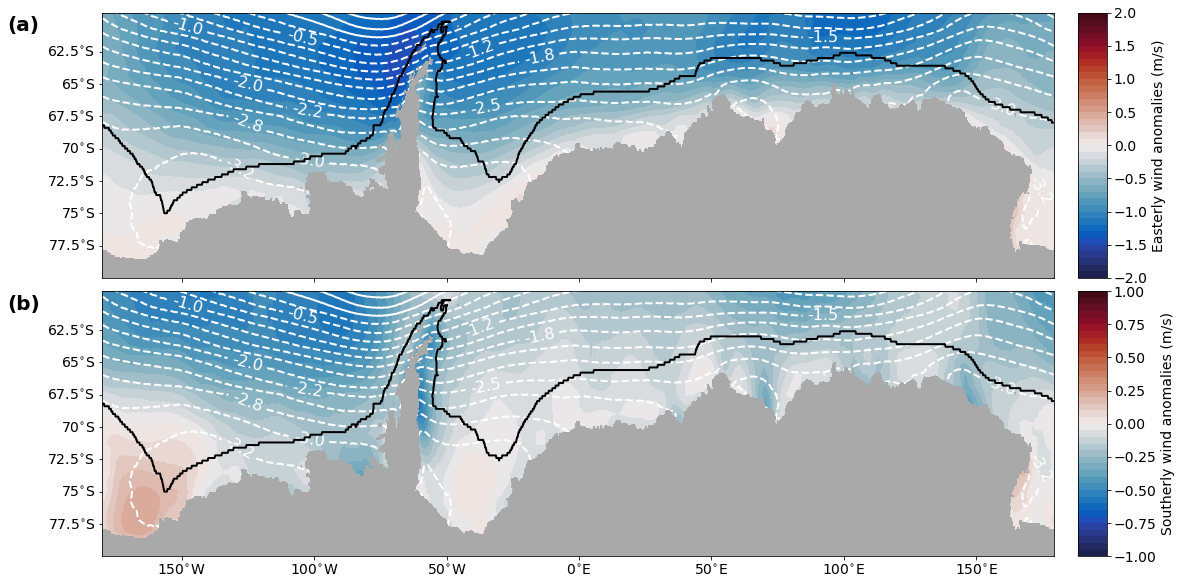

In [26]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 10))
gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03], 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]), fig.add_subplot(gr[1,1])]
for ax, label in zip(axs[:-1], ['(a)', '(b)']):
    ax.text(-0.1, .93, label, transform = ax.transAxes, size = 20, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)
    
c = axs[0].contourf(u['lon'], u['lat'], u-up, 
                    levels = np.arange(-2, 2.1, .1), 
                    cmap = cmocean.cm.balance, zorder = 0)
cbar = fig.colorbar(c, cax = axs[-2])
cbar.set_label('Easterly wind anomalies (m/s)')
#cbar.set_ticks(np.arange(-.15, .2, .05))
c = axs[0].contour(p['lon'], p['lat'], (pp-p)/100,
                   levels = np.arange(-4, 4.25, .25), 
                   colors = ['white'], linewidths = [2], zorder = 1)
axs[0].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=16, zorder = 1)
c = axs[1].contourf(v['lon'], v['lat'], vp-v, 
                    levels = np.arange(-1, 1.05, .05), 
                    cmap = cmocean.cm.balance, zorder = 0)
cbar = fig.colorbar(c, cax = axs[-1])
cbar.set_label('Southerly wind anomalies (m/s)')
c = axs[1].contour(p['lon'], p['lat'], (pp-p)/100,
                   levels = np.arange(-4, 4.25, .25), 
                   colors = ['white'], linewidths = [2], zorder = 1)
axs[1].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=16, zorder = 1)
plt.savefig('../results/v6/sup_wind_changes_eof.jpg', bbox_inches = 'tight', dpi = 800)